In [16]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [17]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


RMSE: 4.551213156394614


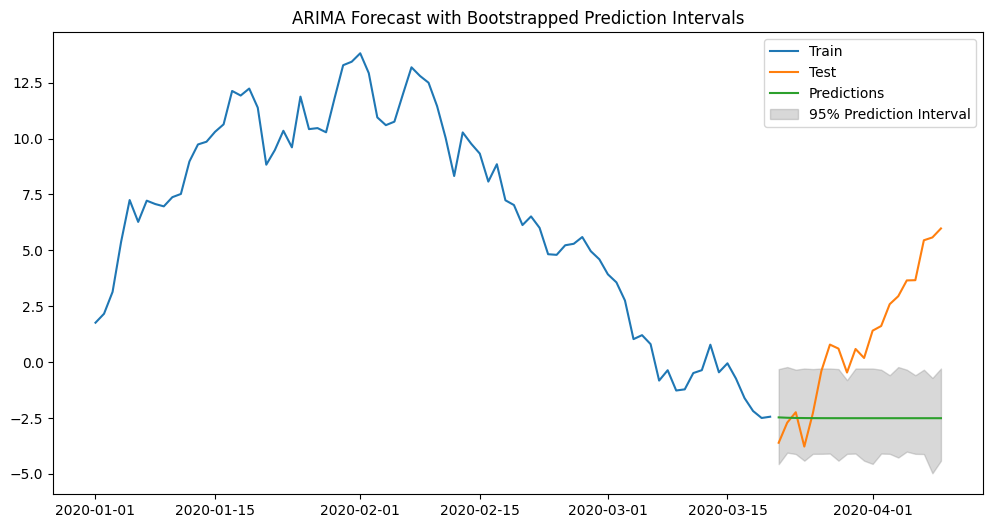

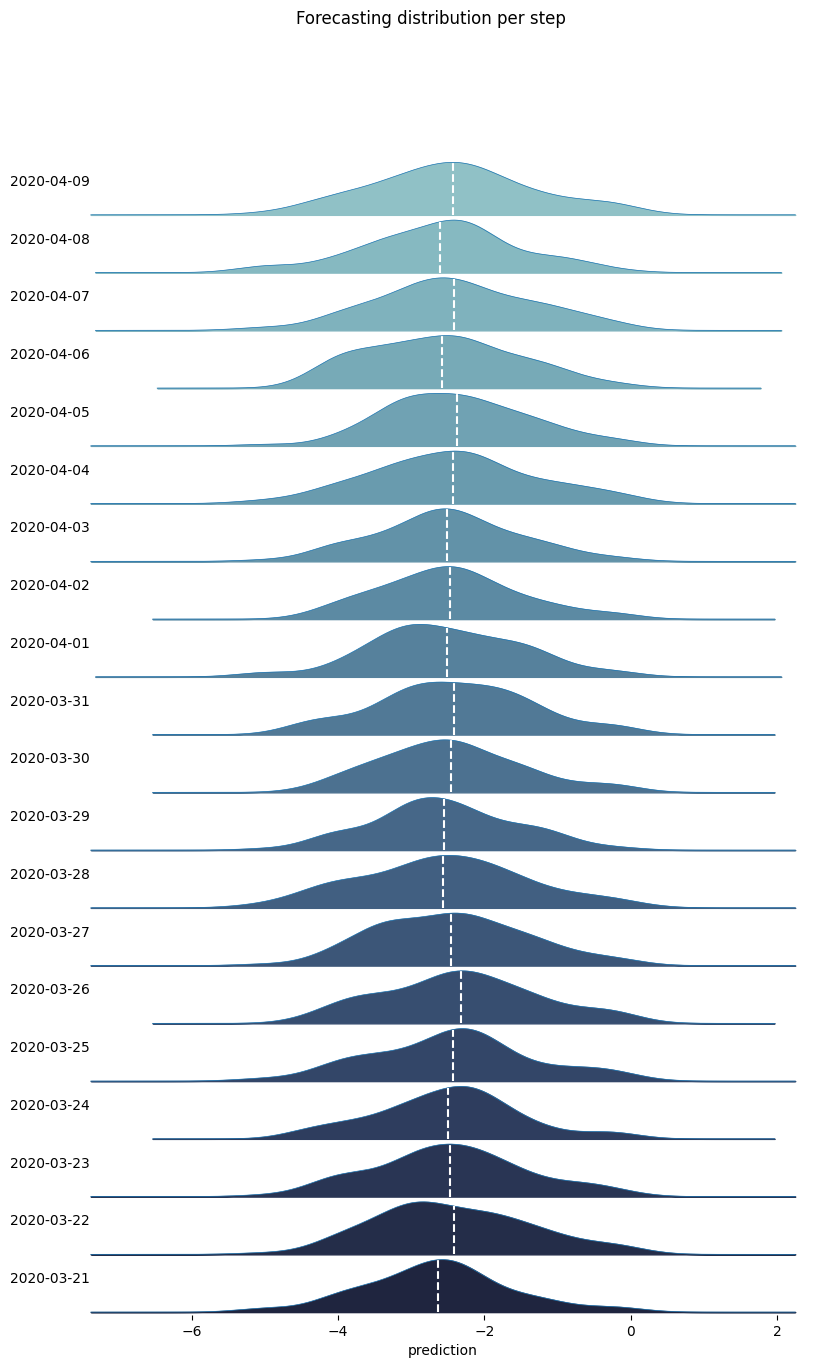

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from typing import Optional, Union, Any
import matplotlib.pyplot as plt
import seaborn as sns

class ARIMAForecaster:
    def __init__(self, order=(2,0,2)):
        self.order = order
        self.model = None
        self.fitted = False
        self.in_sample_residuals = None
        self.last_window = None
        self.transformer_y = None

    def fit(self, y):
        self.model = ARIMA(y, order=self.order)
        self.fitted_model = self.model.fit()
        self.fitted = True
        self.in_sample_residuals = self.fitted_model.resid
        self.last_window = y[-self.order[0]:] if self.order[0] > 0 else y[-1:]

    def predict(self, steps):
        if not self.fitted:
            raise ValueError("Model must be fitted before prediction")
        return self.fitted_model.forecast(steps)

    def _recursive_predict(self, steps, last_window, exog=None):
        return self.fitted_model.forecast(steps=steps, exog=exog)

    def predict_bootstrapping(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> pd.DataFrame:
        if not self.fitted:
            raise ValueError("Model must be fitted before bootstrapping")

        if last_window is None:
            last_window = self.last_window.copy()

        boot_predictions = np.full(
            shape=(steps, n_boot),
            fill_value=np.nan,
            dtype=float
        )
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(low=0, high=10000, size=n_boot)

        residuals = self.in_sample_residuals

        for i in range(n_boot):
            last_window_boot = last_window.copy()
            exog_boot = exog.copy() if exog is not None else None

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(
                a=residuals,
                size=steps,
                replace=True
            )

            for step in range(steps):
                prediction = self._recursive_predict(
                    steps=1,
                    last_window=last_window_boot,
                    exog=exog_boot
                )

                prediction_with_residual = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                    last_window_boot[1:],
                    prediction_with_residual
                )

                if exog is not None:
                    exog_boot = exog_boot[1:]

        boot_predictions = pd.DataFrame(
            data=boot_predictions,
            index=pd.date_range(start=last_window.index[-1] + pd.Timedelta(days=1), periods=steps),
            columns=[f"pred_boot_{i}" for i in range(n_boot)]
        )

        return boot_predictions

def plot_prediction_distribution(
    bootstrapping_predictions: pd.DataFrame,
    bw_method: Optional[Any]=None,
    **fig_kw
) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    fig.suptitle('Forecasting distribution per step')
    return fig

# Main script
if __name__ == "__main__":
    # Load data from CSV
    # Adjust the path and column names as necessary
    np.random.seed(0)
    dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    y = pd.Series(np.cumsum(np.random.randn(100)), index=dates)

    # Split data into train and test
    train = y[:80]
    test = y[80:]

    # Create and fit the model
    forecaster = ARIMAForecaster(order=(1,1,1))
    forecaster.fit(train)

    # Create and fit the model
    forecaster = ARIMAForecaster(order=(1,1,1))  # Adjust order as needed
    forecaster.fit(train)

    # Make predictions
    steps = len(test)
    predictions = forecaster.predict(steps=steps)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE: {rmse}")

    # Perform bootstrapping
    boot_predictions = forecaster.predict_bootstrapping(steps=steps, n_boot=100)

    # Calculate prediction intervals
    lower = boot_predictions.quantile(0.025, axis=1)
    upper = boot_predictions.quantile(0.975, axis=1)

    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(predictions.index, predictions, label='Predictions')
    plt.fill_between(predictions.index, lower, upper, color='gray', alpha=0.3, label='95% Prediction Interval')
    plt.legend()
    plt.title('ARIMA Forecast with Bootstrapped Prediction Intervals')
    plt.show()

    # Plot prediction distribution
    fig = plot_prediction_distribution(boot_predictions, figsize=(10, 15))
    plt.show()

# Prueba Completa

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from typing import Optional, Union

# Load the data
data = pd.read_csv('../data/IPG2211A2N_1.csv', parse_dates=['DATE'], index_col='DATE')



# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]


In [30]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(count=3,
                         label="3y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(count=10,
                         label="10y",
                         step="year",
                         stepmode="backward"),
                    dict(count=20,
                         label="20y",
                         step="year",
                         stepmode="backward"),
                    dict(count=30,
                         label="30y",
                         step="year",
                         stepmode="backward"),
                    dict(count=50,
                         label="50y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Indice de producción"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()


In [31]:
plot_('Indice de producción industrial', 
      (data.index, data['IPG2211A2N'], 'IPG2211A2N'),
      (train.index, train['IPG2211A2N'], 'Train'),
      (test.index, test['IPG2211A2N'], 'Test'))

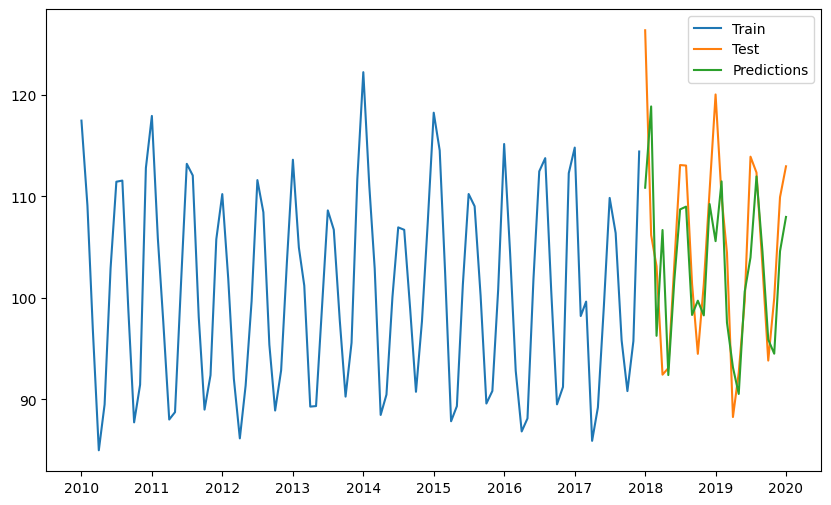

In [36]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Function to perform rolling window forecasting with ARIMA
def rolling_forecast(train, test, window=24, h=1):
    history = train[-window:]
    predictions = []
    
    for t in range(len(test)):
        model = auto_arima(history, seasonal=False, stepwise=True)
        model_fit = model.fit(history)
        yhat = model_fit.predict(n_periods=h)[0]
        predictions.append(yhat)
        history = np.append(history, test[t])
    
    return predictions

# Perform rolling forecast
predictions = rolling_forecast(train['IPG2211A2N'].values, test['IPG2211A2N'].values)
test['Predictions'] = predictions


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train[['IPG2211A2N']], label='Train')
plt.plot(test.index, test['IPG2211A2N'], label='Test')
plt.plot(test.index, test['Predictions'], label='Predictions')
plt.legend()
plt.show()



In [37]:
plot_('Indice de producción industrial', 
      (data.index, data['IPG2211A2N'], 'IPG2211A2N'),
      (train.index, train['IPG2211A2N'], 'Train'),
      (test.index, test['IPG2211A2N'], 'Test'),
      (test.index, test['Predictions'], 'Predictions'))

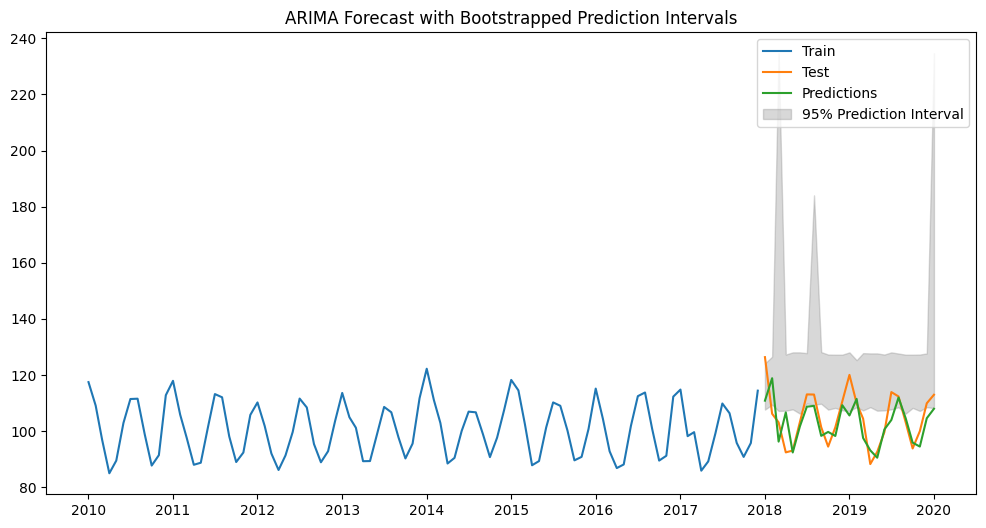

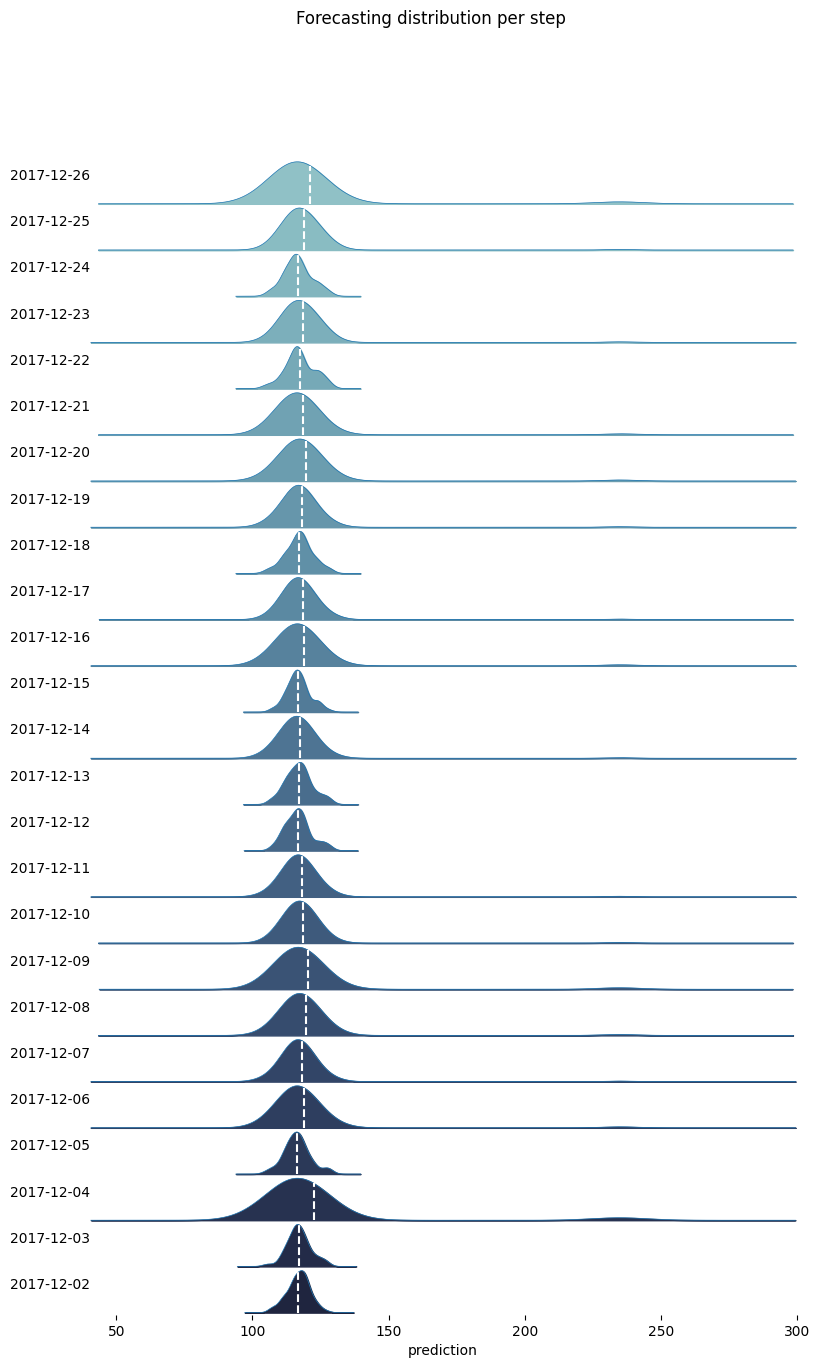

In [41]:
class ARIMAModel:
    def __init__(self, fitted=False):
        self.fitted = fitted
        self.last_window = None
        self.in_sample_residuals = None

    def fit(self, train):
        model = ARIMA(train, order=(5, 1, 0))
        self.model_fit = model.fit()
        self.fitted = True
        self.last_window = train[-24:]
        self.in_sample_residuals = self.model_fit.resid

    def _recursive_predict(self, steps, last_window, exog=None):
        predictions = self.model_fit.forecast(steps=steps)
        return predictions[0]

    def predict_bootstrapping(self, steps, last_window=None, exog=None, n_boot=100, random_state=123, in_sample_residuals=True):
        if not self.fitted:
            raise ValueError("Model must be fitted before bootstrapping")

        if last_window is None:
            last_window = self.last_window.copy()

        boot_predictions = np.full((steps, n_boot), np.nan, dtype=float)
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(0, 10000, size=n_boot)
        residuals = self.in_sample_residuals

        for i in range(n_boot):
            last_window_boot = last_window.copy()
            exog_boot = exog.copy() if exog is not None else None

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(residuals, size=steps, replace=True)

            for step in range(steps):
                prediction = self._recursive_predict(1, last_window_boot, exog_boot)
                prediction_with_residual = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual
                last_window_boot = np.append(last_window_boot[1:], prediction_with_residual)
                if exog is not None:
                    exog_boot = exog_boot[1:]

        boot_predictions = pd.DataFrame(
            boot_predictions,
            index=pd.date_range(start=last_window.index[-1] + pd.Timedelta(days=1), periods=steps),
            columns=[f"pred_boot_{i}" for i in range(n_boot)]
        )

        return boot_predictions

def plot_prediction_distribution(bootstrapping_predictions, bw_method=None, **fig_kw):
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = bootstrapping_predictions.loc[step, :].plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    fig.suptitle('Forecasting distribution per step')
    return fig

# Fit ARIMA model
arima_model = ARIMAModel()
arima_model.fit(train['IPG2211A2N'])

# Generate bootstrap predictions
boot_predictions = arima_model.predict_bootstrapping(
    steps=len(test),
    last_window=train['IPG2211A2N'][-24:],
    n_boot=100
)

# Inverse scale the bootstrap predictions

# Calculate prediction intervals
lower = boot_predictions.quantile(0.025, axis=1)
upper = boot_predictions.quantile(0.975, axis=1)

# Plot the results with prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[['IPG2211A2N']], label='Train')
plt.plot(test.index, test['IPG2211A2N'], label='Test')
plt.plot(test.index, test['Predictions'], label='Predictions')
plt.fill_between(test.index, lower, upper, color='gray', alpha=0.3, label='95% Prediction Interval')
plt.legend()
plt.title('ARIMA Forecast with Bootstrapped Prediction Intervals')
plt.show()

# Plot prediction distribution
fig = plot_prediction_distribution(boot_predictions, figsize=(10, 15))
plt.show()
